## Task: Prepare Modelling data from the formatted datasets

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from statistics import mode, median
import pickle

from factslab.utility import load_glove_embedding
from factslab.datastructures import ConstituencyTree, DependencyTree
from factslab.pytorch.childsumtreelstm import *
#from pytorch.rnnregression import RNNRegressionTrainer
from factslab.pytorch.rnnregression import RNNRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

##Torch
import torch
from torch.nn import MSELoss, L1Loss, SmoothL1Loss, CrossEntropyLoss

#### Formatted datasets location

In [2]:
home_dir = "/Users"

In [3]:
data_path = "../data/"
ud_trees = home_dir + "/sidvash/Dropbox/facts_lab/UD_data_trees/structures.tsv"
train_file_p1 = "bulk_data_temporal_duration.csv"

## Load Data

In [4]:
data_p1 = pd.read_csv(data_path + train_file_p1)

In [5]:
cols = ["split", "worker_id", "sent_token", "sentence_id_1", "sentence_id_2", "sentence", "pred1_text", "pred2_text",
        "pred1_token", "pred2_token", "pred1_root_token", "pred2_root_token", 
       "pred1_duration", "pred2_duration", "pred1_slider", "pred2_slider",
       "pred1_dur_conf", "pred2_dur_conf", "relation_conf", "doc_id"]

out_data = data_p1[cols]

out_data['sent_pred_id1'] = out_data['sentence_id_1'] + " " + out_data['pred1_root_token'].map(lambda x: str(x))
out_data['sent_pred_id2'] = out_data['sentence_id_2'] + " " + out_data['pred2_root_token'].map(lambda x: str(x))

#out_data.head()

## Pre-Process Data

### 1.1 Remove empty slider positions

In [6]:
print(out_data.shape)
out_data = out_data[(out_data.pred1_slider!="{}") &
                   (out_data.pred2_slider!="{}")]
print(out_data.shape)

(85125, 22)
(85124, 22)


### 1.2 Get the slider-values into lists

In [7]:
out_data['pred1_slider_lst'] = out_data['pred1_slider'].map(lambda x: [int(item) for item in x.split("-")])
out_data['pred2_slider_lst'] = out_data['pred2_slider'].map(lambda x: [int(item) for item in x.split("-")])

###  1.3 TIME_ML tags

In [8]:
def time_ml_tag(row, var1, var2):
    '''
    Creates time ML tags from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relations: is before
    '''
    ans = ""
    event1 = getattr(row, var1)
    event2 = getattr(row, var2)
    
    if (event1[0] == event2[0]) and (event1[1] == event2[1]):
        ans = "simultaneous"
    elif event1[1] <= event2[0]:
        ans = "before"
    
    elif event1[0] >= event2[1]:
        ans = "after"
        
    elif event1[1] >= event2[1] and event1[0] <= event2[0]:
        ans = "includes"
        
    elif event1[1] <= event2[1] and event1[0] >= event2[0]:
        ans = "is_included"
    
    elif event1[0] < event2[0] and event1[1] > event2[0]:
        ans = "before_cont"
        
    elif event1[0] < event2[1] and event1[1] > event2[1]:
        ans = "after_cont"
    else: 
        ans = "other"
    return ans

In [9]:
out_data['time_ml'] = out_data.apply(lambda row: time_ml_tag(row, 
                                                             'pred1_slider_lst', 
                                                             'pred2_slider_lst'),
                                    axis=1)
out_data['time_ml'] = out_data['time_ml'].astype('category')
out_data['time_ml_code'] = out_data['time_ml'].cat.codes

print(out_data['time_ml'].cat.categories)

#out_data.head()

Index(['after', 'after_cont', 'before', 'before_cont', 'includes',
       'is_included', 'simultaneous'],
      dtype='object')


### 1.4 Normalize slider Values

In [10]:
def normalize_sliders(row, var_s1, var_s2,
                     param="slider1"):
    '''
    Input:
    var_min_slider: name of the variable having min slider value
    var_max_slider: name of the variable having max slider value
    var_s1: name of the variable having slider1 values
    var_s1: name of the variable having slider2 values
    
    Output:
    norm_slider1: normalized slider1 values
    norm_slider2: normalized slider2 values
    '''
    b1, e1 = getattr(row, var_s1)
    b2, e2 = getattr(row, var_s2)
    
    min_val = min(b1,e1,b2,e2)
    max_val = max(b1,e1,b2,e2)
    
    if param=="slider1":
        try:
            return [round((b1-min_val)/max_val,4), round((e1-min_val)/max_val, 4)]
        except:
            return [0,0]
    else:
        try:
            return [round((b2-min_val)/max_val,4), round((e2-min_val)/max_val,4)]
        except:
            return [0,0]

In [11]:
out_data['norm_slider1'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider1"), axis=1)
out_data['norm_slider2'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider2"), axis=1)
out_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,relation_conf,doc_id,sent_pred_id1,sent_pred_id2,pred1_slider_lst,pred2_slider_lst,time_ml,time_ml_code,norm_slider1,norm_slider2
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,4,10,en-ud-train.conllu 418 17,en-ud-train.conllu 418 19,"[35, 41]","[64, 65]",before,2,"[0.0, 0.0923]","[0.4462, 0.4615]"
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,4,189,en-ud-train.conllu 9490 51,en-ud-train.conllu 9490 53,"[0, 65]","[0, 65]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,4,83,en-ud-train.conllu 7143 8,en-ud-train.conllu 7144 14,"[0, 81]","[0, 81]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,4,126,en-ud-train.conllu 7786 17,en-ud-train.conllu 7787 9,"[35, 44]","[0, 100]",is_included,5,"[0.35, 0.44]","[0.0, 1.0]"
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,4,65,en-ud-train.conllu 5729 4,en-ud-train.conllu 5729 36,"[36, 42]","[0, 26]",after,0,"[0.8571, 1.0]","[0.0, 0.619]"


## Extract Timelines

In [12]:
device=torch.device(type="cpu")

class TimelineModel(torch.nn.Module):
    '''
     A class to extract a simple timeline model from a
     given document's predicate-pair data
    '''
    def __init__(self,
                 data = None,
                 num_preds = None,
                 optimizer_class = torch.optim.Adam,
                device=torch.device(type="cpu") ,
                **kwargs):
        super().__init__()

        self.device = device
        self.fine_loss = L1Loss().to(self.device)
        self.pred_tensor = torch.nn.Parameter(torch.randn(num_preds,2))
        self._optimizer_class = optimizer_class

    def forward(self, local_data, **kwargs):
        '''
        INput: dataframe with cols:
                b1, e1, b2, e2, pred1_dict_idx, pred2_dict_idx
                
        Output: 
        '''
        t_sq = self.pred_tensor**2        
        anchored_tensor = t_sq-t_sq.min()
        
        #Predicted values
        b1 = anchored_tensor[local_data.pred1_dict_idx.values][:,0]
        dur1 = anchored_tensor[local_data.pred1_dict_idx.values][:,1]
        b2 = anchored_tensor[local_data.pred2_dict_idx.values][:,0]
        dur2 = anchored_tensor[local_data.pred2_dict_idx.values][:,1]
        
        return b1, dur1, b2, dur2, anchored_tensor
    
    def fit(self, local_data, epochs=100, **kwargs):
        losses = [10000]
        
        print("#### Model Parameters ####")
        for name,param in self.named_parameters():     
            if param.requires_grad:
                print(name, param.shape) 
        print("##########################") 
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = self._optimizer_class(parameters)
        
        #Actual values
        b1_lst = local_data.b1.values
        e1_lst = local_data.e1.values
        b2_lst = local_data.b2.values
        e2_lst = local_data.e2.values
        
        actuals = self._lsts_to_tensors(b1_lst, e1_lst, b2_lst, e2_lst,
                                        param="float")
        
        for epoch in range(epochs):
            
            preds = self.forward(local_data)
            #zero_grad
            optimizer.zero_grad()
            curr_loss = self._custom_loss(preds, actuals)
            curr_loss.backward()
            optimizer.step()
            
            if epoch==0:
                print("Epoch: {}, Initial-Loss: {}".format(epoch+1, curr_loss))
               
            ## Stop training when loss converges
            if abs(curr_loss.detach() - losses[-1]) < 0.00001:
                print("Epoch: {}, Converging-Loss: {}".format(epoch+1, curr_loss))
                break
                
            losses.append(curr_loss.detach())
                
        return self.predict(preds)
        
    def _custom_loss(self, preds, actuals):
    
        b1_pred, dur1_pred, b2_pred, dur2_pred, _ = preds
        b1_act, e1_act, b2_act, e2_act = actuals
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = t/t_max.view(num_pairs,1)
        
        ## Fine-grained Losses
        l1 = self.fine_loss(t[:,0]-t[:,2], b1_act-b2_act)
        l2 = self.fine_loss(t[:,1]-t[:,2], e1_act-b2_act)
        l3 = self.fine_loss(t[:,3]-t[:,0], e2_act-b1_act)
        l4 = self.fine_loss(t[:,1]-t[:,3], e1_act-e2_act)
        
        total_loss = (l1+l2+l3+l4)/4
        
        return total_loss
        
    def _lsts_to_tensors(self, *args, param=None):
        '''
        Input: list1, list2,......

        Output: [Tensor(list1), tensor(list2),....]

        '''
        if param=="float":
            return [torch.from_numpy(np.array(arg)).float().to(self.device) for arg in args]
        else:
            return [torch.from_numpy(np.array(arg, dtype="int64")).to(self.device) for arg in args]
        
    def predict(self, preds):
        b1_pred, dur1_pred, b2_pred, dur2_pred, pred_timeline = preds
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = (t/t_max.view(num_pairs,1)).detach().numpy()
        

        return t[:,0],t[:,1], t[:,2], t[:,3], pred_timeline.detach().numpy()
        

In [13]:
def extract_preds(doc_id, data, split_data="train"):
    '''
    Extracts a dict of predicates for a given docid and data-split
    Key: pred_sent_id
    Value: predicate-index
    '''
    cols = ['sent_pred_id1', 'sent_pred_id2', 'norm_slider1', 'norm_slider2']
    
    local_data = data[(data.split==split_data) & (out_data.doc_id == doc_id)][cols]
    local_data['b1'] = local_data['norm_slider1'].map(lambda x: x[0])
    local_data['e1'] = local_data['norm_slider1'].map(lambda x: x[1])
    local_data['b2'] = local_data['norm_slider2'].map(lambda x: x[0])
    local_data['e2'] = local_data['norm_slider2'].map(lambda x: x[1])
    
    
    preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
    uniq_preds = np.unique(preds_arr.flatten())
    
    pred_dict = {}
    idx=0
    for pred in uniq_preds:
        pred_dict[pred]=idx
        idx+=1
        
    local_data['pred1_dict_idx'] = local_data['sent_pred_id1'].map(lambda x: pred_dict[x])
    local_data['pred2_dict_idx'] = local_data['sent_pred_id2'].map(lambda x: pred_dict[x])
        
    return pred_dict, idx, local_data

In [14]:
pred_dict, num_preds, local_data = extract_preds(91, out_data)
print(num_preds)
local_data.head()

19


,sent_pred_id1,sent_pred_id2,norm_slider1,norm_slider2,b1,e1,b2,e2,pred1_dict_idx,pred2_dict_idx
2940,en-ud-train.conllu 7259 29,en-ud-train.conllu 7259 31,"[0.0143, 0.1857]","[0.0, 0.5714]",0.0143,0.1857,0.0000,0.5714,2,3
4861,en-ud-train.conllu 7259 4,en-ud-train.conllu 7259 21,"[0.0, 0.8028]","[0.5634, 0.8451]",0.0000,0.8028,0.5634,0.8451,4,1
6626,en-ud-train.conllu 7259 31,en-ud-train.conllu 7259 41,"[0.2874, 0.7356]","[0.0, 0.8851]",0.2874,0.7356,0.0000,0.8851,3,5
10195,en-ud-train.conllu 7270 7,en-ud-train.conllu 7270 13,"[0.0, 0.5294]","[0.0, 0.5294]",0.0000,0.5294,0.0000,0.5294,17,15
10646,en-ud-train.conllu 7259 19,en-ud-train.conllu 7259 41,"[0.0, 0.4423]","[0.4423, 0.8269]",0.0000,0.4423,0.4423,0.8269,0,5


In [15]:
def extract_predictions(data, split_data="train"):
    '''
    Extract predicted slider values and document timelines for
    a given data
    '''
    data_mod = data[data.split==split_data]
    
    doc_ids = data_mod['doc_id'].unique()
    
    doc_timelines = {}
    
    for i,doc_id in enumerate(doc_ids):
        pred_dict, num_preds, local_data = extract_preds(doc_id, data_mod, 
                                                   split_data=split_data)
        
        ## Run Timeline Model on current docid's data
        model = TimelineModel(data = local_data,
                 num_preds = num_preds,
                device=torch.device(type="cpu"))
        
        pred_b1, pred_e1, pred_b2, pred_e2, pred_timeline  = model.fit(local_data, epochs=100000)
        doc_timelines[doc_id] = pred_timeline
        
        ## Store prediction-values into the dataset
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b1'] = pred_b1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e1'] = pred_e1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b2'] = pred_b2
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e2'] = pred_e2

        print("Documents processed: {}, Curr_docid: {}\n".format(i+1, doc_id))
        
    return data_mod, doc_timelines

In [16]:
train_data, train_doc_timlines = extract_predictions(out_data, split_data="train")

#### Model Parameters ####
pred_tensor torch.Size([171, 2])
##########################
Epoch: 1, Initial-Loss: 0.5823254585266113
Epoch: 1732, Converging-Loss: 0.19848832488059998
Documents processed: 1, Curr_docid: 10

#### Model Parameters ####
pred_tensor torch.Size([136, 2])
##########################
Epoch: 1, Initial-Loss: 0.5436937212944031
Epoch: 1433, Converging-Loss: 0.20402921736240387
Documents processed: 2, Curr_docid: 189

#### Model Parameters ####
pred_tensor torch.Size([309, 2])
##########################
Epoch: 1, Initial-Loss: 0.5855492353439331
Epoch: 1687, Converging-Loss: 0.1540265530347824
Documents processed: 3, Curr_docid: 83

#### Model Parameters ####
pred_tensor torch.Size([34, 2])
##########################
Epoch: 1, Initial-Loss: 0.58233642578125
Epoch: 1449, Converging-Loss: 0.19738700985908508
Documents processed: 4, Curr_docid: 126

#### Model Parameters ####
pred_tensor torch.Size([66, 2])
##########################
Epoch: 1, Initial-Loss: 0.5626989006

Epoch: 1628, Converging-Loss: 0.20535561442375183
Documents processed: 38, Curr_docid: 80

#### Model Parameters ####
pred_tensor torch.Size([55, 2])
##########################
Epoch: 1, Initial-Loss: 0.5229026675224304
Epoch: 1625, Converging-Loss: 0.1939753293991089
Documents processed: 39, Curr_docid: 158

#### Model Parameters ####
pred_tensor torch.Size([206, 2])
##########################
Epoch: 1, Initial-Loss: 0.5940516591072083
Epoch: 1611, Converging-Loss: 0.2082708179950714
Documents processed: 40, Curr_docid: 43

#### Model Parameters ####
pred_tensor torch.Size([148, 2])
##########################
Epoch: 1, Initial-Loss: 0.5208063125610352
Epoch: 1558, Converging-Loss: 0.19440676271915436
Documents processed: 41, Curr_docid: 185

#### Model Parameters ####
pred_tensor torch.Size([291, 2])
##########################
Epoch: 1, Initial-Loss: 0.5901217460632324
Epoch: 1599, Converging-Loss: 0.19562017917633057
Documents processed: 42, Curr_docid: 193

#### Model Parameters ###

Documents processed: 75, Curr_docid: 304

#### Model Parameters ####
pred_tensor torch.Size([147, 2])
##########################
Epoch: 1, Initial-Loss: 0.5943101644515991
Epoch: 1956, Converging-Loss: 0.19389483332633972
Documents processed: 76, Curr_docid: 52

#### Model Parameters ####
pred_tensor torch.Size([622, 2])
##########################
Epoch: 1, Initial-Loss: 0.5853121280670166
Epoch: 1814, Converging-Loss: 0.20035478472709656
Documents processed: 77, Curr_docid: 17

#### Model Parameters ####
pred_tensor torch.Size([87, 2])
##########################
Epoch: 1, Initial-Loss: 0.5983782410621643
Epoch: 1503, Converging-Loss: 0.2118811458349228
Documents processed: 78, Curr_docid: 19

#### Model Parameters ####
pred_tensor torch.Size([58, 2])
##########################
Epoch: 1, Initial-Loss: 0.6107659339904785
Epoch: 1178, Converging-Loss: 0.21267470717430115
Documents processed: 79, Curr_docid: 169

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
#################

Epoch: 1246, Converging-Loss: 0.20511455833911896
Documents processed: 113, Curr_docid: 170

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6475425362586975
Epoch: 1191, Converging-Loss: 0.1637095957994461
Documents processed: 114, Curr_docid: 388

#### Model Parameters ####
pred_tensor torch.Size([51, 2])
##########################
Epoch: 1, Initial-Loss: 0.5521914958953857
Epoch: 1469, Converging-Loss: 0.19590789079666138
Documents processed: 115, Curr_docid: 522

#### Model Parameters ####
pred_tensor torch.Size([57, 2])
##########################
Epoch: 1, Initial-Loss: 0.49601274728775024
Epoch: 1575, Converging-Loss: 0.16104939579963684
Documents processed: 116, Curr_docid: 529

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.4995131194591522
Epoch: 1148, Converging-Loss: 0.18265512585639954
Documents processed: 117, Curr_docid: 507

#### Model Parameter

Epoch: 1352, Converging-Loss: 0.17035818099975586
Documents processed: 150, Curr_docid: 20

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.528083086013794
Epoch: 1087, Converging-Loss: 0.17790737748146057
Documents processed: 151, Curr_docid: 488

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5561526417732239
Epoch: 928, Converging-Loss: 0.19796398282051086
Documents processed: 152, Curr_docid: 394

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.551144540309906
Epoch: 1089, Converging-Loss: 0.2366730123758316
Documents processed: 153, Curr_docid: 510

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.5742359161376953
Epoch: 1239, Converging-Loss: 0.21262258291244507
Documents processed: 154, Curr_docid: 498

#### Model Parameters ##

Documents processed: 187, Curr_docid: 453

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.5582148432731628
Epoch: 541, Converging-Loss: 0.2064206749200821
Documents processed: 188, Curr_docid: 210

#### Model Parameters ####
pred_tensor torch.Size([138, 2])
##########################
Epoch: 1, Initial-Loss: 0.5395398736000061
Epoch: 1478, Converging-Loss: 0.21480277180671692
Documents processed: 189, Curr_docid: 8

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.5093120336532593
Epoch: 1002, Converging-Loss: 0.24237704277038574
Documents processed: 190, Curr_docid: 472

#### Model Parameters ####
pred_tensor torch.Size([59, 2])
##########################
Epoch: 1, Initial-Loss: 0.6062800884246826
Epoch: 1757, Converging-Loss: 0.18798387050628662
Documents processed: 191, Curr_docid: 151

#### Model Parameters ####
pred_tensor torch.Size([27, 2])
##############

Documents processed: 224, Curr_docid: 435

#### Model Parameters ####
pred_tensor torch.Size([34, 2])
##########################
Epoch: 1, Initial-Loss: 0.6027084589004517
Epoch: 1585, Converging-Loss: 0.15811403095722198
Documents processed: 225, Curr_docid: 124

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5993923544883728
Epoch: 1540, Converging-Loss: 0.2440526783466339
Documents processed: 226, Curr_docid: 505

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.6071066856384277
Epoch: 1224, Converging-Loss: 0.19739554822444916
Documents processed: 227, Curr_docid: 462

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5895293354988098
Epoch: 1542, Converging-Loss: 0.17049747705459595
Documents processed: 228, Curr_docid: 392

#### Model Parameters ####
pred_tensor torch.Size([78, 2])
###########

Epoch: 909, Converging-Loss: 0.21987494826316833
Documents processed: 262, Curr_docid: 305

#### Model Parameters ####
pred_tensor torch.Size([28, 2])
##########################
Epoch: 1, Initial-Loss: 0.5736907720565796
Epoch: 1175, Converging-Loss: 0.19480982422828674
Documents processed: 263, Curr_docid: 114

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.5614285469055176
Epoch: 1451, Converging-Loss: 0.18834415078163147
Documents processed: 264, Curr_docid: 494

#### Model Parameters ####
pred_tensor torch.Size([26, 2])
##########################
Epoch: 1, Initial-Loss: 0.6484619379043579
Epoch: 1582, Converging-Loss: 0.24774004518985748
Documents processed: 265, Curr_docid: 473

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5425764918327332
Epoch: 1269, Converging-Loss: 0.22679898142814636
Documents processed: 266, Curr_docid: 500

#### Model Parameter

Documents processed: 299, Curr_docid: 348

#### Model Parameters ####
pred_tensor torch.Size([19, 2])
##########################
Epoch: 1, Initial-Loss: 0.5827784538269043
Epoch: 1402, Converging-Loss: 0.16912518441677094
Documents processed: 300, Curr_docid: 413

#### Model Parameters ####
pred_tensor torch.Size([65, 2])
##########################
Epoch: 1, Initial-Loss: 0.6050131320953369
Epoch: 1295, Converging-Loss: 0.1813155859708786
Documents processed: 301, Curr_docid: 171

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.509407103061676
Epoch: 716, Converging-Loss: 0.18927404284477234
Documents processed: 302, Curr_docid: 228

#### Model Parameters ####
pred_tensor torch.Size([31, 2])
##########################
Epoch: 1, Initial-Loss: 0.5646243691444397
Epoch: 1349, Converging-Loss: 0.2511286735534668
Documents processed: 303, Curr_docid: 110

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##############

Documents processed: 336, Curr_docid: 411

#### Model Parameters ####
pred_tensor torch.Size([75, 2])
##########################
Epoch: 1, Initial-Loss: 0.550189197063446
Epoch: 1246, Converging-Loss: 0.15918800234794617
Documents processed: 337, Curr_docid: 21

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.3901885151863098
Epoch: 890, Converging-Loss: 0.21357446908950806
Documents processed: 338, Curr_docid: 246

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.49463891983032227
Epoch: 1003, Converging-Loss: 0.1576007902622223
Documents processed: 339, Curr_docid: 432

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.5694982409477234
Epoch: 1870, Converging-Loss: 0.2118893414735794
Documents processed: 340, Curr_docid: 422

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##############

Epoch: 1476, Converging-Loss: 0.183816596865654
Documents processed: 374, Curr_docid: 301

#### Model Parameters ####
pred_tensor torch.Size([21, 2])
##########################
Epoch: 1, Initial-Loss: 0.6328722238540649
Epoch: 1623, Converging-Loss: 0.15668195486068726
Documents processed: 375, Curr_docid: 416

#### Model Parameters ####
pred_tensor torch.Size([36, 2])
##########################
Epoch: 1, Initial-Loss: 0.5335615873336792
Epoch: 1333, Converging-Loss: 0.22520580887794495
Documents processed: 376, Curr_docid: 116

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.5163093209266663
Epoch: 1187, Converging-Loss: 0.1881384551525116
Documents processed: 377, Curr_docid: 404

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.43894076347351074
Epoch: 887, Converging-Loss: 0.17790289223194122
Documents processed: 378, Curr_docid: 306

#### Model Parameters #

Documents processed: 411, Curr_docid: 206

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.483340859413147
Epoch: 1077, Converging-Loss: 0.12998829782009125
Documents processed: 412, Curr_docid: 293

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.6432791948318481
Epoch: 1074, Converging-Loss: 0.14909906685352325
Documents processed: 413, Curr_docid: 333

#### Model Parameters ####
pred_tensor torch.Size([23, 2])
##########################
Epoch: 1, Initial-Loss: 0.5546338558197021
Epoch: 1640, Converging-Loss: 0.18976005911827087
Documents processed: 414, Curr_docid: 454

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.47057223320007324
Epoch: 1015, Converging-Loss: 0.12231487035751343
Documents processed: 415, Curr_docid: 434

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########

Epoch: 1448, Converging-Loss: 0.20936621725559235
Documents processed: 449, Curr_docid: 155

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5725700855255127
Epoch: 1490, Converging-Loss: 0.2042136937379837
Documents processed: 450, Curr_docid: 424

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.548103392124176
Epoch: 785, Converging-Loss: 0.20599403977394104
Documents processed: 451, Curr_docid: 299

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.6959390044212341
Epoch: 1312, Converging-Loss: 0.19239802658557892
Documents processed: 452, Curr_docid: 400

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5031908750534058
Epoch: 927, Converging-Loss: 0.1378641575574875
Documents processed: 453, Curr_docid: 478

#### Model Parameters ##

Documents processed: 486, Curr_docid: 300

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.43134748935699463
Epoch: 1085, Converging-Loss: 0.18938642740249634
Documents processed: 487, Curr_docid: 204

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.6460176706314087
Epoch: 1147, Converging-Loss: 0.2532120943069458
Documents processed: 488, Curr_docid: 212

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.5915607810020447
Epoch: 1271, Converging-Loss: 0.220138818025589
Documents processed: 489, Curr_docid: 248

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.6365953087806702
Epoch: 1290, Converging-Loss: 0.13827967643737793
Documents processed: 490, Curr_docid: 217

#### Model Parameters ####
pred_tensor torch.Size([16, 2])
###############

Epoch: 1094, Converging-Loss: 0.15646913647651672
Documents processed: 524, Curr_docid: 239

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.7194864153862
Epoch: 1038, Converging-Loss: 0.14771932363510132
Documents processed: 525, Curr_docid: 291

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.8605931997299194
Epoch: 1425, Converging-Loss: 0.20952041447162628
Documents processed: 526, Curr_docid: 221

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.48759543895721436
Epoch: 1032, Converging-Loss: 0.1673944890499115
Documents processed: 527, Curr_docid: 207

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.5717097520828247
Epoch: 593, Converging-Loss: 0.18909621238708496
Documents processed: 528, Curr_docid: 234

#### Model Parameters ####

In [17]:
train_data['predicted_slider1'] = train_data.apply(lambda row: [round(row.predicted_b1,4) , 
                                                                round(row.predicted_e1,4)], axis=1)
train_data['predicted_slider2'] = train_data.apply(lambda row: [round(row.predicted_b2,4), 
                                                                round(row.predicted_e2,4)], axis=1)
train_data['predicted_timeml'] = train_data.apply(lambda row: time_ml_tag(row, 
                                                             'predicted_slider1', 
                                                             'predicted_slider2'),
                                                                    axis=1)
train_data.drop(['predicted_b1','predicted_e1', 'predicted_b2',  'predicted_e2'],axis=1, inplace=True)
train_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,sent_pred_id2,pred1_slider_lst,pred2_slider_lst,time_ml,time_ml_code,norm_slider1,norm_slider2,predicted_slider1,predicted_slider2,predicted_timeml
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,en-ud-train.conllu 418 19,"[35, 41]","[64, 65]",before,2,"[0.0, 0.0923]","[0.4462, 0.4615]","[0.0053, 0.1341]","[0.0, 0.3419]",is_included
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,en-ud-train.conllu 9490 53,"[0, 65]","[0, 65]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]","[0.0, 0.7379]","[0.0059, 0.7052]",includes
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,en-ud-train.conllu 7144 14,"[0, 81]","[0, 81]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]","[0.0456, 0.7889]","[0.0, 0.788]",after_cont
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,en-ud-train.conllu 7787 9,"[35, 44]","[0, 100]",is_included,5,"[0.35, 0.44]","[0.0, 1.0]","[0.2448, 0.44]","[0.0, 0.8948]",is_included
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,en-ud-train.conllu 5729 36,"[36, 42]","[0, 26]",after,0,"[0.8571, 1.0]","[0.0, 0.619]","[0.6253, 0.8878]","[0.0, 0.506]",after


## Relations Change Statistics

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [21]:
match = sum(train_data['time_ml'] == train_data['predicted_timeml'])
total = train_data.shape[0]
print("% of Relations remained same: {}".format(match/total))

% of Relations remained same: 0.4618067148951957


before          17357
includes        11058
is_included      8899
before_cont      5865
simultaneous     5734
after            4080
after_cont        917
Name: time_ml, dtype: int64


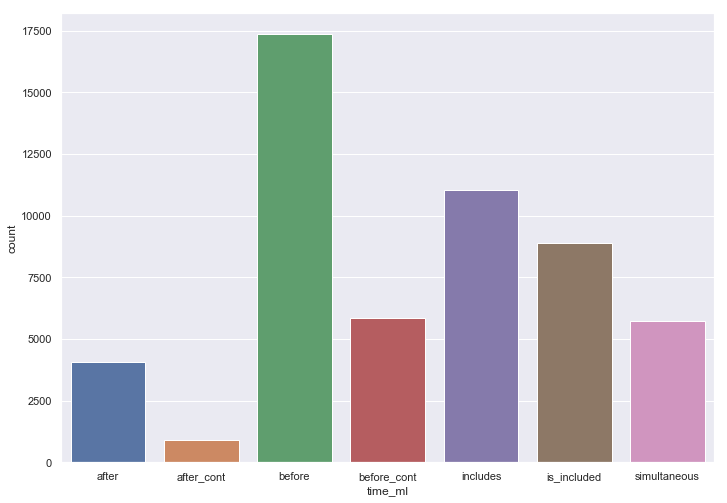

In [22]:
print(train_data.time_ml.value_counts())
sns.countplot(x='time_ml', data=train_data)
plt.show()

before_cont     15645
before          10573
includes         9901
is_included      9518
after_cont       5680
after            2585
simultaneous        8
Name: predicted_timeml, dtype: int64


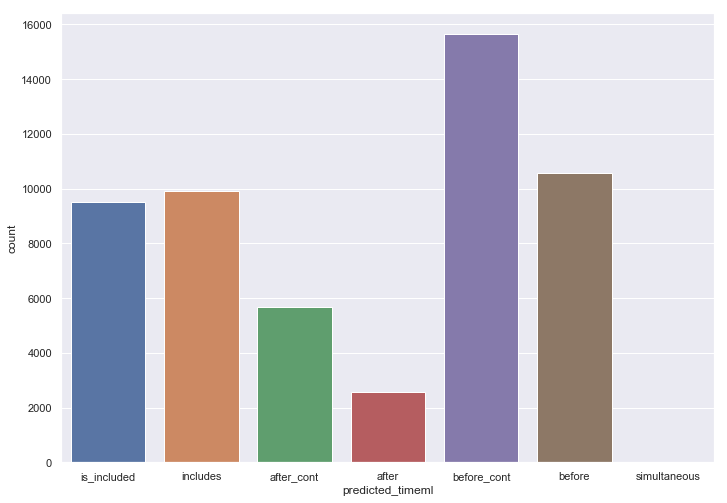

In [23]:
print(train_data.predicted_timeml.value_counts())
sns.countplot(x='predicted_timeml', data=train_data)
plt.show()

## Document Timeline - Example

In [25]:
train_doc_timlines[265]

array([[1.0556188 , 0.0890578 ],
       [0.38974938, 0.15730116],
       [0.78522074, 0.25465146],
       [0.36570653, 0.18297824],
       [0.3266507 , 0.29969993],
       [0.5166913 , 0.2160658 ],
       [1.1276435 , 0.42262682],
       [2.8127193 , 5.085665  ],
       [4.0704236 , 0.7723    ],
       [1.7127535 , 0.1803514 ],
       [0.        , 1.8199422 ]], dtype=float32)

In [26]:
cols = ['sent_pred_id1', 'sent_pred_id2', 'norm_slider1', 'norm_slider2']
local_data = train_data[(train_data.doc_id == 265)][cols]
preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
uniq_preds = np.unique(preds_arr.flatten())
print(uniq_preds)

['en-ud-train.conllu 10181 0' 'en-ud-train.conllu 10182 13'
 'en-ud-train.conllu 10182 15' 'en-ud-train.conllu 10182 23'
 'en-ud-train.conllu 10182 7' 'en-ud-train.conllu 10183 12'
 'en-ud-train.conllu 10183 20' 'en-ud-train.conllu 10184 13'
 'en-ud-train.conllu 10184 15' 'en-ud-train.conllu 10184 4'
 'en-ud-train.conllu 10184 7']
